# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Import Dataset

In [2]:
df = pd.read_csv('/Users/jetindersingh/Downloads/incident_gas_transmission_gathering_jan2010_present-2/df.csv')
df

,REPORT_RECEIVED_DATE,IYEAR,REPORT_TYPE,OPERATOR_ID,NAME,OPERATOR_CITY_NAME,OPERATOR_STATE_ABBREVIATION,COMMODITY_RELEASED_TYPE,UNINTENTIONAL_RELEASE,INTENTIONAL_RELEASE,...,ACCIDENT_PSIG,GAS_FLOW_IN_PIPE_IN_MCF,MOP_PSIG,ACCIDENT_PRESSURE,PIPELINE_FUNCTION,ACCIDENT_IDENTIFIER,INVESTIGATION_STATUS,CAUSE,CAUSE_DETAILS,INCIDENT
0,4/24/2023,2023,ORIGINAL,13750,NORTHERN NATURAL GAS CO,OMAHA,NE,NATURAL GAS,7876.0,17055.0,...,880.0,583.0,991.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,AIR PATROL,"YES, SPECIFY INVESTIGATION RESULT(S): (SELECT ...",CORROSION FAILURE,EXTERNAL CORROSION,1
1,4/12/2023,2023,ORIGINAL,19570,TRANSCONTINENTAL GAS PIPE LINE COMPANY,TULSA,OK,NATURAL GAS,16200.0,0.0,...,695.0,164000.0,800.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,NOTIFICATION FROM PUBLIC,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",EQUIPMENT FAILURE,DEFECTIVE OR LOOSE TUBING OR FITTING,1
2,4/25/2023,2023,ORIGINAL,40139,"VENICE GATHERING SYSTEM, L.L.C.",THE WOODLANDS,TX,NATURAL GAS,2540.0,3370.0,...,314.0,0.0,1182.0,PRESSURE DID NOT EXCEED MAOP,TYPE C GATHERING,OTHER,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",CORROSION FAILURE,INTERNAL CORROSION,1
3,4/21/2023,2023,ORIGINAL,31618,ENTERPRISE PRODUCTS OPERATING LLC,HOUSTON,TX,NATURAL GAS,13000.0,0.0,...,871.0,14000.0,960.0,PRESSURE DID NOT EXCEED MAOP,TYPE C GATHERING,"SCADA-BASED INFORMATION (SUCH AS ALARM(S), ALE...","NO, THE FACILITY WAS NOT MONITORED BY A CONTRO...",OTHER INCIDENT CAUSE,UNKNOWN,1
4,4/17/2023,2023,SUPPLEMENTAL FINAL,22655,"WBI ENERGY TRANSMISSION, INC.",BISMARCK,ND,NATURAL GAS,23105.0,0.0,...,688.0,0.0,720.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS","YES, SPECIFY INVESTIGATION RESULT(S): (SELECT ...",EQUIPMENT FAILURE,MALFUNCTION OF CONTROL/RELIEF EQUIPMENT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,3/10/2010,2010,SUPPLEMENTAL FINAL,602,CENTERPOINT ENERGY GAS TRANSMISSION,HOUSTON,TX,NATURAL GAS,30142.0,0.0,...,855.0,NaN,1000.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,"SCADA-BASED INFORMATION (SUCH AS ALARM(S), ALE...","NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",NATURAL FORCE DAMAGE,TEMPERATURE,1
1631,4/5/2010,2010,SUPPLEMENTAL FINAL,32341,"SOUTHEAST SUPPLY HEADER, LLC",HOUSTON,TX,NATURAL GAS,239.0,29184.0,...,1005.0,NaN,1200.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,NOTIFICATION FROM PUBLIC,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",MATERIAL FAILURE OF PIPE OR WELD,"DESIGN-, CONSTRUCTION-, INSTALLATION-, OR FABR...",1
1632,5/4/2010,2010,SUPPLEMENTAL FINAL,13750,NORTHERN NATURAL GAS CO,OMAHA,NE,NATURAL GAS,1970.0,NaN,...,420.0,NaN,960.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,GROUND PATROL BY OPERATOR OR ITS CONTRACTOR,"NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",EQUIPMENT FAILURE,THREADED CONNECTION/COUPLING FAILURE,1
1633,3/12/2010,2010,SUPPLEMENTAL FINAL,18516,SOUTHERN NATURAL GAS CO,BIRMINGHAM,AL,NATURAL GAS,41176.0,0.0,...,740.0,NaN,750.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,"LOCAL OPERATING PERSONNEL, INCLUDING CONTRACTORS","NO, THE OPERATOR DID NOT FIND THAT AN INVESTIG...",CORROSION FAILURE,EXTERNAL CORROSION,1


The data contains incidents reported for various commodity types. Hence, filtering out data other than Natural Gas incidents

In [3]:
df_org = df.query('COMMODITY_RELEASED_TYPE == "NATURAL GAS"')

Removing unwanted columns that were either duplicate information or may not be significantly contribute to the current analysis. The data is renamed as df_org representing Oroginal Data before applying factorization to categorical data and normalizing data using StandardScaler. 

In [4]:
df_org = df.drop(columns = ['REPORT_RECEIVED_DATE','REPORT_TYPE','OPERATOR_ID', 'OPERATOR_CITY_NAME', 'ACCIDENT_IDENTIFIER', 'INVESTIGATION_STATUS',
                   'UPSTREAM_ACTION_TAKEN', 'COATING_APPLIED_IND', 'MANUFACTURED_YEAR', 'PUNCTURE_AXIAL','PUNCTURE_CIRCUM', 'EST_COST_OPER_PAID',
                   'GAS_COST_IN_MCF', 'NUM_PERSONS_HOSP_NOT_OVNGHT','NUM_INJURED_TREATED_BY_EMT','NUM_RESIDENT_BUILDING_AFFCTD',
                   'NUM_BUSINESS_BUILDING_AFFCTD','WILDLIFE_IMPACT_IND','ACCIDENT_IDENTIFIER','INVESTIGATION_STATUS', 'SHUTDOWN_DATETIME',
                        'COMMODITY_RELEASED_TYPE', 'RESTART_DATETIME' ], axis= 1)

In [5]:
df_org

,IYEAR,NAME,OPERATOR_STATE_ABBREVIATION,UNINTENTIONAL_RELEASE,INTENTIONAL_RELEASE,FATALITY_IND,FATAL,INJURY_IND,INJURE,SHUTDOWN_DUE_ACCIDENT_IND,...,EST_COST_EMERGENCY,PRPTY,ACCIDENT_PSIG,GAS_FLOW_IN_PIPE_IN_MCF,MOP_PSIG,ACCIDENT_PRESSURE,PIPELINE_FUNCTION,CAUSE,CAUSE_DETAILS,INCIDENT
0,2023,NORTHERN NATURAL GAS CO,NE,7876.0,17055.0,NO,0,NO,0,YES,...,50000.0,708837,880.0,583.0,991.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,CORROSION FAILURE,EXTERNAL CORROSION,1
1,2023,TRANSCONTINENTAL GAS PIPE LINE COMPANY,OK,16200.0,0.0,NO,0,NO,0,NO,...,0.0,37350,695.0,164000.0,800.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,EQUIPMENT FAILURE,DEFECTIVE OR LOOSE TUBING OR FITTING,1
2,2023,"VENICE GATHERING SYSTEM, L.L.C.",TX,2540.0,3370.0,NO,0,NO,0,NaN,...,200000.0,211820,314.0,0.0,1182.0,PRESSURE DID NOT EXCEED MAOP,TYPE C GATHERING,CORROSION FAILURE,INTERNAL CORROSION,1
3,2023,ENTERPRISE PRODUCTS OPERATING LLC,TX,13000.0,0.0,NO,0,NO,0,NO,...,500.0,160820,871.0,14000.0,960.0,PRESSURE DID NOT EXCEED MAOP,TYPE C GATHERING,OTHER INCIDENT CAUSE,UNKNOWN,1
4,2023,"WBI ENERGY TRANSMISSION, INC.",ND,23105.0,0.0,NO,0,NO,0,NO,...,1700.0,49559,688.0,0.0,720.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,EQUIPMENT FAILURE,MALFUNCTION OF CONTROL/RELIEF EQUIPMENT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630,2010,CENTERPOINT ENERGY GAS TRANSMISSION,TX,30142.0,0.0,NO,0,NO,0,NO,...,400.0,173889,855.0,NaN,1000.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,NATURAL FORCE DAMAGE,TEMPERATURE,1
1631,2010,"SOUTHEAST SUPPLY HEADER, LLC",TX,239.0,29184.0,NO,0,NO,0,NO,...,0.0,561563,1005.0,NaN,1200.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,MATERIAL FAILURE OF PIPE OR WELD,"DESIGN-, CONSTRUCTION-, INSTALLATION-, OR FABR...",1
1632,2010,NORTHERN NATURAL GAS CO,NE,1970.0,NaN,NO,0,NO,0,YES,...,3500.0,479100,420.0,NaN,960.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,EQUIPMENT FAILURE,THREADED CONNECTION/COUPLING FAILURE,1
1633,2010,SOUTHERN NATURAL GAS CO,AL,41176.0,0.0,NO,0,NO,0,YES,...,20000.0,406699,740.0,NaN,750.0,PRESSURE DID NOT EXCEED MAOP,TRANSMISSION SYSTEM,CORROSION FAILURE,EXTERNAL CORROSION,1


In [6]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   IYEAR                           1635 non-null   int64  
 1   NAME                            1635 non-null   object 
 2   OPERATOR_STATE_ABBREVIATION     1635 non-null   object 
 3   UNINTENTIONAL_RELEASE           1635 non-null   float64
 4   INTENTIONAL_RELEASE             1560 non-null   float64
 5   FATALITY_IND                    1635 non-null   object 
 6   FATAL                           1635 non-null   int64  
 7   INJURY_IND                      1635 non-null   object 
 8   INJURE                          1635 non-null   int64  
 9   SHUTDOWN_DUE_ACCIDENT_IND       1575 non-null   object 
 10  IGNITE_IND                      1635 non-null   object 
 11  ON_OFF_SHORE                    1635 non-null   object 
 12  LOCATION_TYPE                   14

Managing null values for categorical and numerical data 

In [7]:
df_org[['INTENTIONAL_RELEASE','DEPTH_OF_COVER','PIPE_DIAMETER', 'PIR_RADIUS', 'EST_COST_UNINTENTIONAL_RELEASE', 'EST_COST_INTENTIONAL_RELEASE','EST_COST_PROP_DAMAGE', 'EST_COST_EMERGENCY', 'GAS_FLOW_IN_PIPE_IN_MCF']]= df_org[['INTENTIONAL_RELEASE','DEPTH_OF_COVER','PIPE_DIAMETER', 'PIR_RADIUS', 'EST_COST_UNINTENTIONAL_RELEASE', 'EST_COST_INTENTIONAL_RELEASE','EST_COST_PROP_DAMAGE', 'EST_COST_EMERGENCY', 'GAS_FLOW_IN_PIPE_IN_MCF']].fillna(0)
df_org[['SHUTDOWN_DUE_ACCIDENT_IND', 'LOCATION_TYPE','INCIDENT_AREA_TYPE','INCIDENT_AREA_SUBTYPE', 'PIPE_MANUFACTURER', 'LEAK_TYPE', 'CROSSING', 'HEAT_DAMAGE_IND']] = \
df_org[['SHUTDOWN_DUE_ACCIDENT_IND','LOCATION_TYPE','INCIDENT_AREA_TYPE','INCIDENT_AREA_SUBTYPE', 'PIPE_MANUFACTURER', 'LEAK_TYPE', 'CROSSING', 'HEAT_DAMAGE_IND']].fillna('Unknown')

Applying factorize function as column transformer for categorical data 

In [8]:
df_org['SHUTDOWN_DUE_ACCIDENT_IND'] = df_org['SHUTDOWN_DUE_ACCIDENT_IND'].factorize()[0]
df_org['PIPE_MANUFACTURER'] = df_org['PIPE_MANUFACTURER'].factorize() [0]
df_org['LEAK_TYPE'] = df_org['LEAK_TYPE'].factorize()[0]
df_org['CROSSING'] = df_org['CROSSING'].factorize()[0]
df_org['HEAT_DAMAGE_IND'] = df_org['HEAT_DAMAGE_IND'].factorize()[0]
df_org['NAME'] = df_org['NAME'].factorize()[0]
df_org['OPERATOR_STATE_ABBREVIATION'] = df_org['OPERATOR_STATE_ABBREVIATION'].factorize()[0]
df_org['FATALITY_IND'] = df_org['FATALITY_IND'].factorize()[0]
df_org['INJURY_IND'] = df_org['INJURY_IND'].factorize()[0]
df_org['IGNITE_IND'] = df_org['IGNITE_IND'].factorize()[0]
df_org['ON_OFF_SHORE'] = df_org['ON_OFF_SHORE'].factorize()[0]
df_org['INCIDENT_AREA_TYPE'] = df_org['INCIDENT_AREA_TYPE'].factorize()[0]
df_org['INCIDENT_AREA_SUBTYPE'] = df_org['INCIDENT_AREA_SUBTYPE'].factorize()[0]
df_org['SYSTEM_PART_INVOLVED'] = df_org['SYSTEM_PART_INVOLVED'].factorize()[0]
df_org['ITEM_INVOLVED'] = df_org['ITEM_INVOLVED'].factorize()[0]
df_org['COATING'] = df_org['COATING'].factorize()[0]
df_org['INSTALLATION_YEAR'] = df_org['INSTALLATION_YEAR'].factorize()[0]
df_org['MATERIAL_INVOLVED'] = df_org['MATERIAL_INVOLVED'].factorize()[0]
df_org['RELEASE_TYPE'] = df_org['RELEASE_TYPE'].factorize()[0]
df_org['CLASS_LOCATION_TYPE'] = df_org['CLASS_LOCATION_TYPE'].factorize()[0]
df_org['COULD_BE_HCA'] = df_org['COULD_BE_HCA'].factorize()[0]
df_org['ACCIDENT_PRESSURE'] = df_org['ACCIDENT_PRESSURE'].factorize()[0]
df_org['PIPELINE_FUNCTION'] = df_org['PIPELINE_FUNCTION'].factorize()[0]
df_org['CAUSE'] = df_org['CAUSE'].factorize()[0]
df_org['CAUSE_DETAILS'] = df_org['CAUSE_DETAILS'].factorize()[0]
df_org['LOCATION_TYPE'] = df_org['LOCATION_TYPE'].factorize()[0]

In [9]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1635 entries, 0 to 1634
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   IYEAR                           1635 non-null   int64  
 1   NAME                            1635 non-null   int64  
 2   OPERATOR_STATE_ABBREVIATION     1635 non-null   int64  
 3   UNINTENTIONAL_RELEASE           1635 non-null   float64
 4   INTENTIONAL_RELEASE             1635 non-null   float64
 5   FATALITY_IND                    1635 non-null   int64  
 6   FATAL                           1635 non-null   int64  
 7   INJURY_IND                      1635 non-null   int64  
 8   INJURE                          1635 non-null   int64  
 9   SHUTDOWN_DUE_ACCIDENT_IND       1635 non-null   int64  
 10  IGNITE_IND                      1635 non-null   int64  
 11  ON_OFF_SHORE                    1635 non-null   int64  
 12  LOCATION_TYPE                   16

Applying Standards Scaler to the entire dataset

In [10]:
scaled = StandardScaler()
df2 = df_org.drop(columns = 'INCIDENT', axis = 1)
df3 = pd.DataFrame(scaled.fit_transform(df2), columns = df2.columns)
df3['INCIDENT'] = df_org['INCIDENT']
df3['INCIDENT'] = df3['INCIDENT'].fillna(1)
df_scaled = df3

Observing Correlation between various attributes 

In [11]:
corr_incident = df_scaled.corr()['INCIDENT']
corr_incident

IYEAR                            NaN
NAME                             NaN
OPERATOR_STATE_ABBREVIATION      NaN
UNINTENTIONAL_RELEASE            NaN
INTENTIONAL_RELEASE              NaN
FATALITY_IND                     NaN
FATAL                            NaN
INJURY_IND                       NaN
INJURE                           NaN
SHUTDOWN_DUE_ACCIDENT_IND        NaN
IGNITE_IND                       NaN
ON_OFF_SHORE                     NaN
LOCATION_TYPE                    NaN
INCIDENT_AREA_TYPE               NaN
INCIDENT_AREA_SUBTYPE            NaN
DEPTH_OF_COVER                   NaN
CROSSING                         NaN
SYSTEM_PART_INVOLVED             NaN
ITEM_INVOLVED                    NaN
PIPE_DIAMETER                    NaN
PIPE_MANUFACTURER                NaN
COATING                          NaN
INSTALLATION_YEAR                NaN
MATERIAL_INVOLVED                NaN
RELEASE_TYPE                     NaN
LEAK_TYPE                        NaN
CLASS_LOCATION_TYPE              NaN
C

Getting NaN as the correlation values. this may be due to fact that the data considered for tha assessment contains all the reported incident, therfore, making the data significantly biased. 

In [12]:
corr_cause = df_scaled.corr()['CAUSE']
corr_cause

IYEAR                            -0.053809
NAME                              0.014873
OPERATOR_STATE_ABBREVIATION       0.126371
UNINTENTIONAL_RELEASE             0.033137
INTENTIONAL_RELEASE              -0.038140
FATALITY_IND                      0.093043
FATAL                             0.053050
INJURY_IND                        0.068189
INJURE                            0.030792
SHUTDOWN_DUE_ACCIDENT_IND        -0.046069
IGNITE_IND                        0.061420
ON_OFF_SHORE                     -0.272531
LOCATION_TYPE                    -0.377927
INCIDENT_AREA_TYPE               -0.310398
INCIDENT_AREA_SUBTYPE            -0.146398
DEPTH_OF_COVER                    0.085826
CROSSING                         -0.234655
SYSTEM_PART_INVOLVED             -0.226819
ITEM_INVOLVED                    -0.073506
PIPE_DIAMETER                     0.039597
PIPE_MANUFACTURER                 0.037514
COATING                          -0.061213
INSTALLATION_YEAR                 0.052491
MATERIAL_IN

In [14]:
cause_corr = df_scaled.corr()['LEAK_TYPE']
cause_corr

IYEAR                             0.054831
NAME                             -0.030761
OPERATOR_STATE_ABBREVIATION       0.022815
UNINTENTIONAL_RELEASE             0.002898
INTENTIONAL_RELEASE               0.014882
FATALITY_IND                     -0.025332
FATAL                            -0.021256
INJURY_IND                       -0.030871
INJURE                           -0.015087
SHUTDOWN_DUE_ACCIDENT_IND         0.056764
IGNITE_IND                       -0.023372
ON_OFF_SHORE                     -0.157739
LOCATION_TYPE                    -0.070246
INCIDENT_AREA_TYPE               -0.051372
INCIDENT_AREA_SUBTYPE            -0.041732
DEPTH_OF_COVER                    0.009483
CROSSING                         -0.161895
SYSTEM_PART_INVOLVED             -0.038977
ITEM_INVOLVED                     0.243143
PIPE_DIAMETER                    -0.266410
PIPE_MANUFACTURER                -0.173032
COATING                          -0.156367
INSTALLATION_YEAR                -0.028043
MATERIAL_IN

In [21]:
X_inc = df_scaled.drop(columns= ['INCIDENT'], axis = 1)
y_inc = df_scaled['INCIDENT']

In [22]:
X_inc_train, X_inc_test, y_inc_train, y_inc_test = train_test_split(X_inc, y_inc , test_size= 0.2, random_state= 42)

# OneClass SVM Method

In [24]:
nus = [0.001, 0.01, 0.1,0.5, 0.75, 1]
gammas = ['scale', 'auto']
tuned_parameters = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma' : gammas, 'nu': nus}

oc_svm = OneClassSVM()
grid_search = GridSearchCV(estimator = oc_svm, param_grid = tuned_parameters, n_jobs=4, scoring= 'f1')

In [25]:
grid_search.fit(X_inc)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 req

GridSearchCV(estimator=OneClassSVM(), n_jobs=4,
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.001, 0.01, 0.1, 0.5, 0.75, 1]},
             scoring='f1')

In [26]:
nus = [0.001]
gammas = ['scale']
tuned_parameters = {'kernel' : ['linear'], 'gamma' : gammas, 'nu': nus}

oc_svm_tuned = OneClassSVM()
grid_search_tuned = GridSearchCV(estimator = oc_svm, param_grid = tuned_parameters, n_jobs=4, scoring= 'f1')

In [27]:
grid_search_tuned.fit(X_inc)

/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jetindersingh/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 req

GridSearchCV(estimator=OneClassSVM(), n_jobs=4,
             param_grid={'gamma': ['scale'], 'kernel': ['linear'],
                         'nu': [0.001]},
             scoring='f1')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [28]:
grid_search.best_score_

nan

In [29]:
y_inc_pred = grid_search.predict(X_inc_test)
y_inc_pred

array([ 1,  1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,
       -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
       -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1

In [30]:
accuracy_score(y_inc_pred, y_inc_test)

0.764525993883792

In [31]:
cm = confusion_matrix(y_inc_pred, y_inc_test)


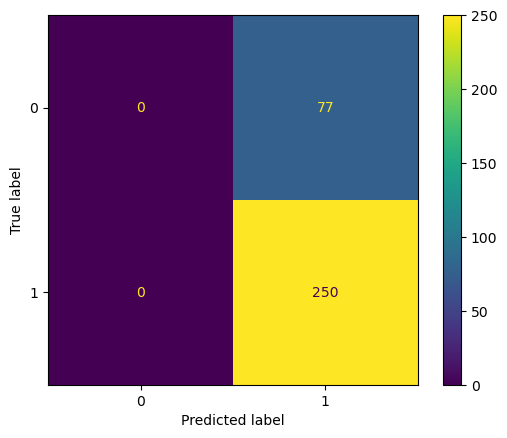

In [32]:
ConfusionMatrixDisplay(confusion_matrix= cm).plot()

# Isolation Forest Method

In [33]:
model_IF = IsolationForest(max_features=1.0, bootstrap=False, n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [34]:
model_IF.fit(X_inc_train)

IsolationForest()

In [35]:
y_if_pred = model_IF.predict(X_inc_test)

In [36]:
accuracy_score(y_if_pred, y_inc_test)

0.9327217125382263